Found 2510 images belonging to 2 classes.
Found 626 images belonging to 2 classes.
Epoch 1/30
157/157 [==============================] - 46s 245ms/step - loss: 0.5111 - accuracy: 0.7789 - auc: 0.8626 - val_loss: 0.3284 - val_accuracy: 0.8898 - val_auc: 0.9483 - lr: 0.0010
Epoch 2/30
157/157 [==============================] - 34s 217ms/step - loss: 0.2919 - accuracy: 0.8908 - auc: 0.9456 - val_loss: 0.2314 - val_accuracy: 0.9058 - val_auc: 0.9676 - lr: 0.0010
Epoch 3/30
157/157 [==============================] - 34s 216ms/step - loss: 0.2910 - accuracy: 0.8916 - auc: 0.9470 - val_loss: 0.2276 - val_accuracy: 0.9073 - val_auc: 0.9676 - lr: 0.0010
Epoch 4/30
157/157 [==============================] - 34s 213ms/step - loss: 0.2328 - accuracy: 0.9080 - auc: 0.9654 - val_loss: 0.2025 - val_accuracy: 0.9345 - val_auc: 0.9749 - lr: 0.0010
Epoch 5/30
157/157 [==============================] - 34s 215ms/step - loss: 0.2171 - accuracy: 0.9139 - auc: 0.9708 - val_loss: 0.1766 - val_accuracy: 0.931

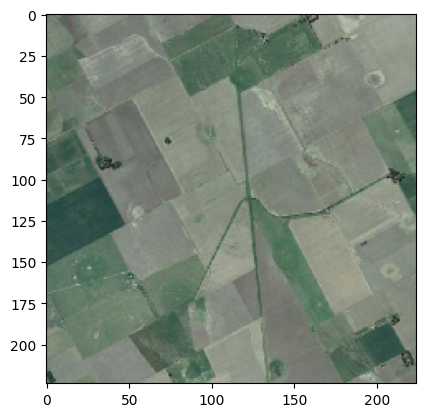

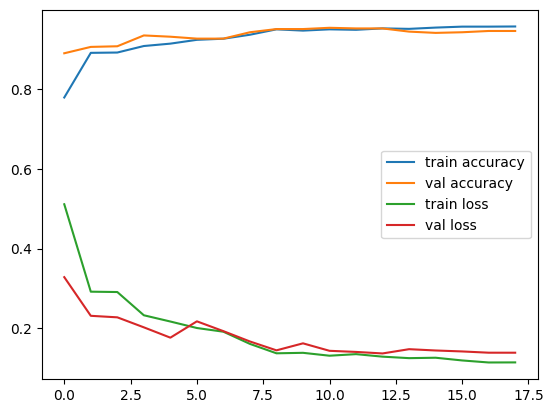

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Configure TensorFlow to use the GPU
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Set up data generators for train and test data with data augmentation
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(
        'train',
        target_size=(224, 224),
        batch_size=16,
        class_mode='binary',
        classes=['construction', 'non_construction'])

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        'test',
        target_size=(224, 224),
        batch_size=16,
        class_mode='binary',
        classes=['construction', 'non_construction'])

# Construct CNN architecture with Dropout regularization
input = Input(shape=(224, 224, 3))
x = Conv2D(32, (3, 3), activation='relu')(input)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(inputs=input, outputs=x)


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.AUC()])


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.1, verbose=1)

history = model.fit(train_generator, steps_per_epoch=len(train_generator), epochs=30, validation_data=test_generator, validation_steps=len(test_generator), callbacks=[early_stopping, reduce_lr])

model.save('cnn.h5')


1/1 [==============================] - 0s 22ms/step
The image is predicted to be non_construction


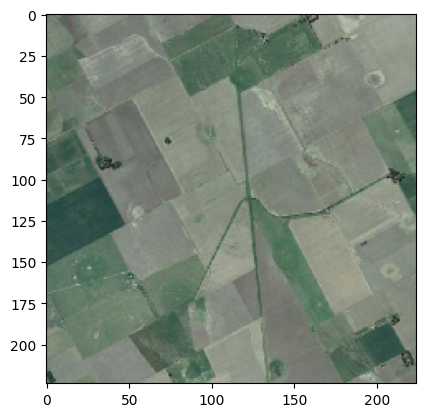

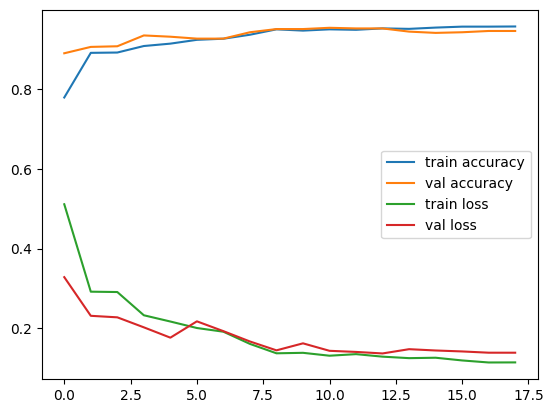

3

In [ ]:
# Load the image
img = load_img('test1.jpg', target_size=(224, 224))
img_array = img_to_array(img)
img_array = img_array.reshape((1, 224, 224, 3))
img_array = img_array / 255.

# Make a prediction
prediction = model.predict(img_array)

# Get the class labels
class_labels = list(test_generator.class_indices.keys())

# Print the selected class
if prediction < 0.5:
    print("The image is predicted to be", class_labels[0])
else:
    print("The image is predicted to be", class_labels[1])

# Display the image
plt.imshow(img)
plt.show()


import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.savefig('CNN.png')
plt.show()


40/40 [==============================] - 4s 87ms/step
Confusion Matrix
[[183 152]
 [158 133]]


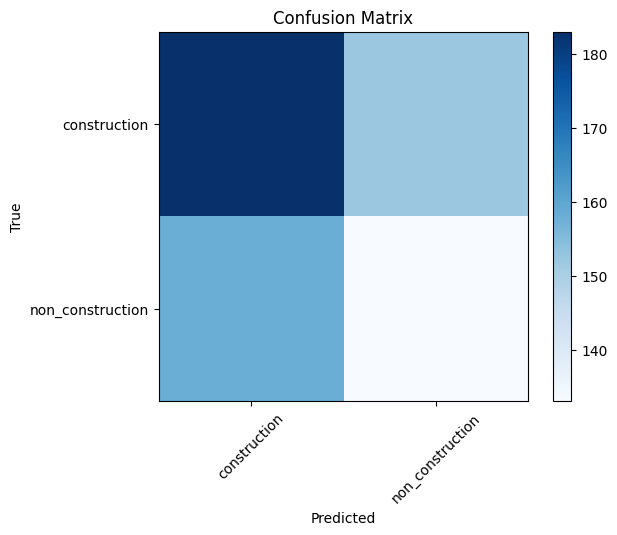

In [ ]:
from sklearn.metrics import confusion_matrix

# Get the predicted classes for the test data
y_pred = model.predict(test_generator).round()

# Get the true classes for the test data
y_true = test_generator.classes

# Get the class labels
class_labels = list(test_generator.class_indices.keys())

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Print the confusion matrix
print('Confusion Matrix')
print(cm)

# Plot the confusion matrix
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()